In [1]:
import numpy as np
import pandas as pd
import scanpy
import cell2sentence
import torch
from transformers import GPT2TokenizerFast, GPT2ForSequenceClassification, GPT2Config, TrainingArguments, Trainer
from datasets import load_dataset, Dataset
import evaluate
import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
tokenizer = GPT2TokenizerFast.from_pretrained("./output/checkpoint-105540/")
model = GPT2ForSequenceClassification.from_pretrained("./output/checkpoint-105540/").to(device)

In [4]:
label2id ={
0: 'B cell',
1: 'CD4-positive, alpha-beta T cell',
2: 'CD8-positive, alpha-beta T cell',
3: 'CD8-positive, alpha-beta cytotoxic T cell',
4: 'blood vessel endothelial cell',
5: 'dendritic cell',
6: 'endothelial cell of lymphatic vessel',
7: 'epithelial cell',
8: 'epithelial cell of stratum germinativum of esophagus',
9: 'immature B cell',
10: 'mast cell',
11: 'mucus secreting cell',
12: 'phagocyte',
13: 'stratified epithelial cell',
14: 'stromal cell'}

In [2]:
eso = scanpy.read_h5ad("data/eso.h5ad")
eso_c2s = cell2sentence.transforms.csdata_from_adata(eso)
cell_sents = eso_c2s.create_sentence_lists()
cell_sents = [' '.join(inner_list) for inner_list in cell_sents]

100%|██████████| 87947/87947 [00:35<00:00, 2500.33it/s]


In [6]:
def predict_label(model, tokenizer, text, device="cuda"):
    inputs = tokenizer(text, return_tensors="pt", padding='max_length', truncation=True).to(device)
    outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    label = predictions.item()
    return label


In [7]:
pred_types = []
for cell in cell_sents:
    pred_types.append(label2id[predict_label(model, tokenizer, cell)])

In [8]:
len(pred_types)

87947

In [9]:
eso.obs['pred_cell_type'] = pred_types

c:\Users\johnz\anaconda3\envs\celldl\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\johnz\anaconda3\envs\celldl\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


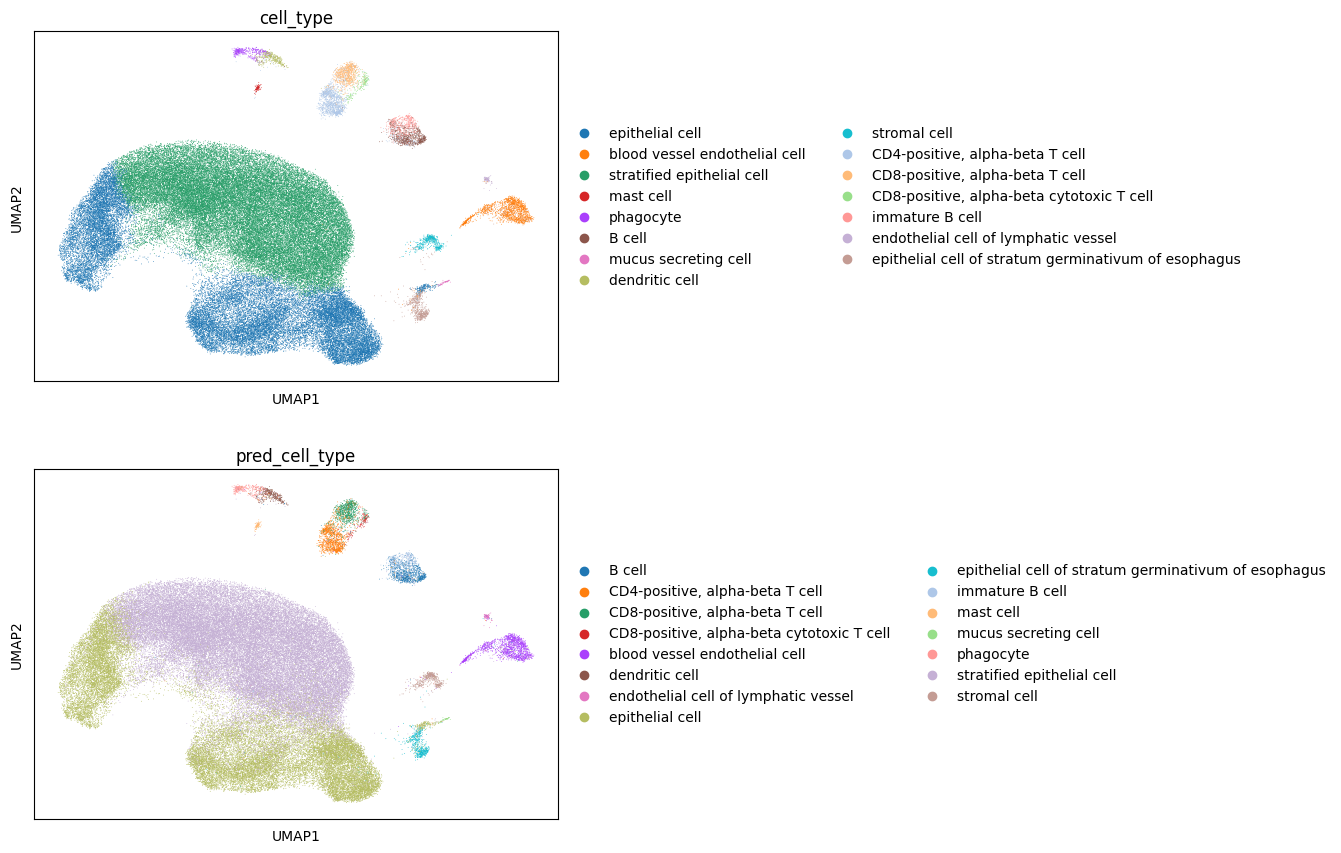

In [12]:
scanpy.pl.umap(eso, color=['cell_type', 'pred_cell_type'], ncols=1)

In [18]:
eso.obs['agree'] = (eso.obs['cell_type'] == eso.obs['pred_cell_type']).astype(str)

c:\Users\johnz\anaconda3\envs\celldl\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\johnz\anaconda3\envs\celldl\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\johnz\anaconda3\envs\celldl\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


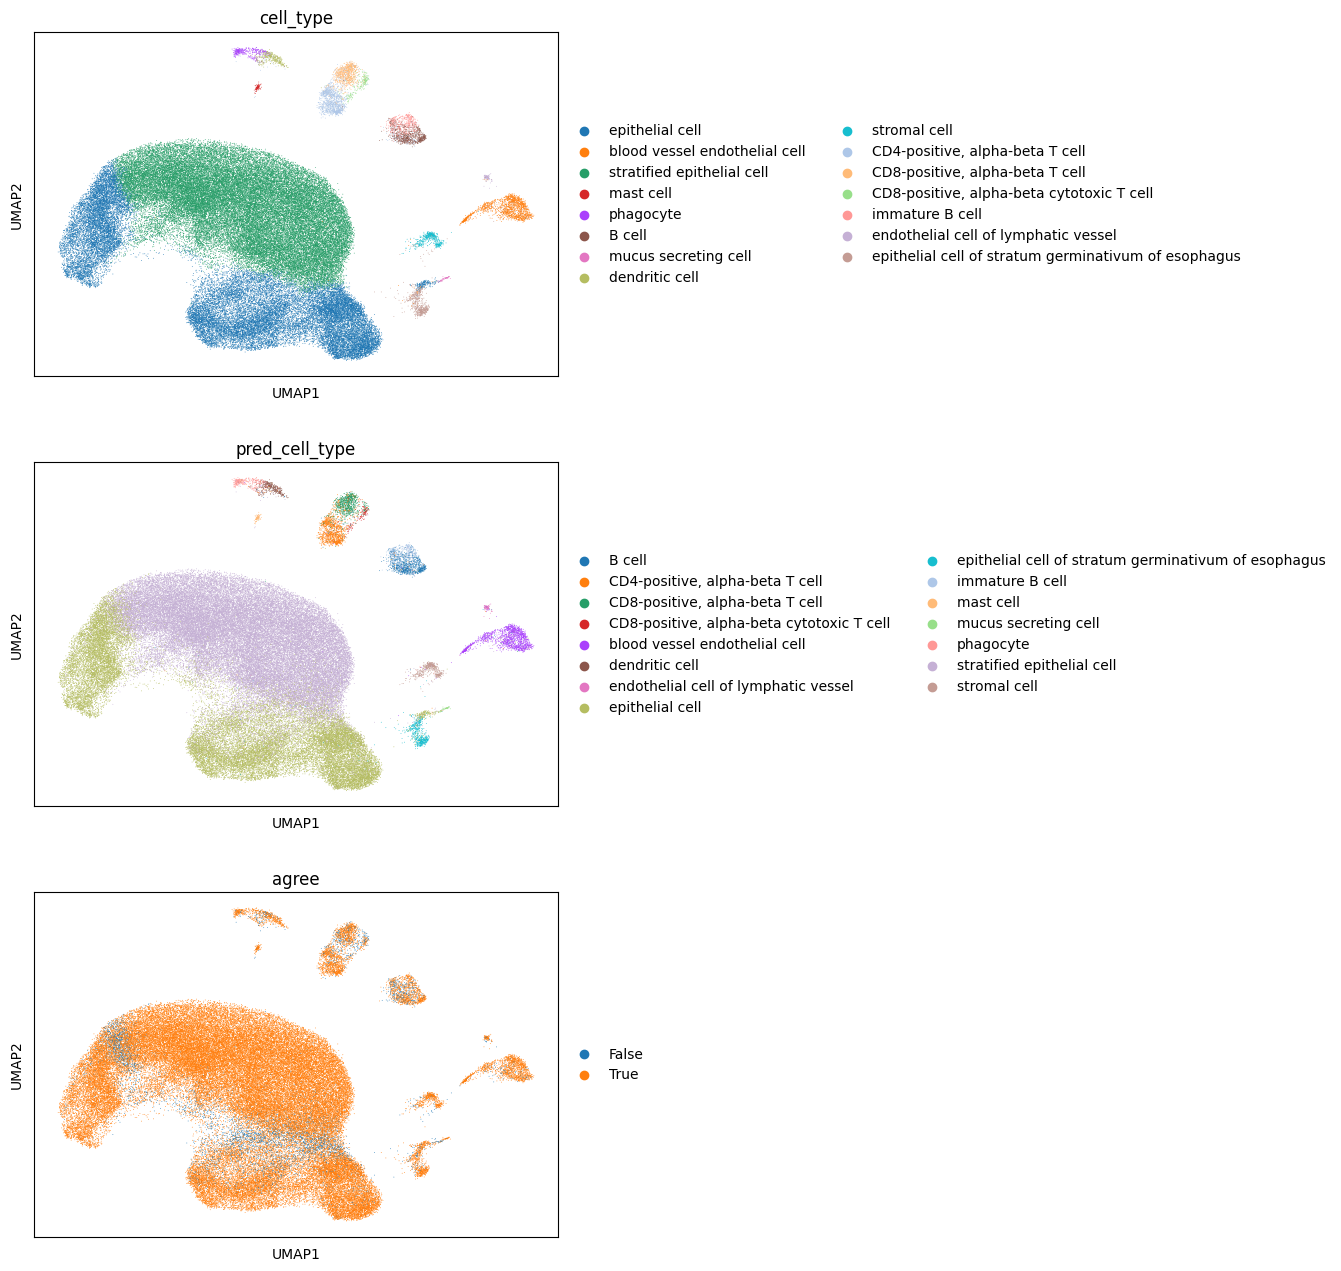

In [19]:
scanpy.pl.umap(eso, color=['cell_type', 'pred_cell_type', 'agree'], ncols=1)

In [28]:
def batch_predict_labels(model, tokenizer, texts, batch_size, label_map, device="cuda"):
    # create list to store predicted labels
    predicted_labels = []

    # iterate over texts in batches
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        # tokenize batch texts
        inputs = tokenizer(batch_texts, return_tensors="pt", padding='max_length', truncation=True).to(device)

        # make predictions with model
        outputs = model(**inputs)
        logits = outputs.logits
        _, predicted = torch.max(logits, dim=-1)

        # convert integer-encoded predictions to string labels
        batch_predicted_labels = [label_map[prediction.item()] for prediction in predicted]

        # add batch predicted labels to list
        predicted_labels.extend(batch_predicted_labels)

        del inputs, outputs, logits, predicted

    return predicted_labels


In [29]:
batch_size = 4
pred_types = batch_predict_labels(model, tokenizer, cell_sents, batch_size, label2id, device)


OutOfMemoryError: CUDA out of memory. Tried to allocate 12.00 MiB (GPU 0; 8.00 GiB total capacity; 7.25 GiB already allocated; 0 bytes free; 7.29 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [36]:
cell_sents[3]

'ENSG00000143546 ENSG00000163220 ENSG00000171401 ENSG00000121552 ENSG00000160213 ENSG00000251562 ENSG00000163209 ENSG00000170477 ENSG00000198804 ENSG00000133710 ENSG00000196754 ENSG00000140519 ENSG00000164687 ENSG00000189334 ENSG00000135046 ENSG00000198938 ENSG00000205420 ENSG00000137818 ENSG00000106211 ENSG00000198712 ENSG00000156508 ENSG00000231500 ENSG00000084207 ENSG00000198886 ENSG00000111640 ENSG00000137154 ENSG00000133112 ENSG00000112378 ENSG00000198034 ENSG00000272398 ENSG00000163191 ENSG00000148303 ENSG00000112306 ENSG00000177954 ENSG00000164587 ENSG00000233927 ENSG00000163682 ENSG00000143536 ENSG00000108107 ENSG00000125968 ENSG00000175793 ENSG00000143947 ENSG00000140988 ENSG00000205542 ENSG00000197747 ENSG00000198899 ENSG00000197756 ENSG00000197956 ENSG00000138326 ENSG00000122026 ENSG00000198763 ENSG00000089157 ENSG00000198918 ENSG00000105372 ENSG00000142541 ENSG00000188643 ENSG00000213741 ENSG00000174748 ENSG00000167526 ENSG00000182774 ENSG00000198727 ENSG00000083845 ENSG000

In [35]:
eso.obs['cell_type'][3]

'stratified epithelial cell'